# Imports and Custom Modules

This section of the notebook imports essential libraries and custom modules required for data analysis and visualization:

- **Standard Libraries**:
    - `sys`: Provides access to system-specific parameters and functions.
    - `pandas`: Used for data manipulation and analysis.
    - `random`: Generates random numbers for simulation purposes.
    - `datetime`: Handles date and time operations.

- **Custom Modules**:
    - `generate_signals`: A custom module for generating trading signals based on stock data.
    - `generate_candlestick_df`: A custom module for formatting data for candlestick chart generation.

In [21]:
import sys
import pandas as pd
import random
from datetime import datetime, timedelta
from generate_signals import generate_signals  # Importing signal generation function

# Setup and Customization Variables

This section provides a brief description of the key variables used for configuring and running the program:

1. **Timeframe and Date Variables**:
    - `start_date` and `end_date`: Define the simulation's date range.
    - `random_start_date` and `random_dates`: Specify random start dates for the simulation.
    
2. **Market Session Variables**:
    - `market_open`, `market_close`, and `pre_market_start`: Define the pre-market, open, and close times.

3. **Simulation Parameters**:
    - `number_of_days`: Number of days to plot and retrieve data for.
    - `intervalAmt`: Time interval for candlestick data aggregation.

In [22]:
# Generate a random start date within the range
start_date = datetime(2023, 5, 1)
end_date = datetime(2025, 4, 4)
number_of_days = random.randint(2, 7)
intervalAmt = 15
# Define market session times
market_open = '09:30:00'
market_close = '16:00:00'
pre_market_start = '04:00:00'

# Calculate the maximum possible start date to ensure the range fits `number_of_days`
max_start_date = end_date - timedelta(days=number_of_days - 1)
random_start_date = start_date + timedelta(days=random.randint(0, (max_start_date - start_date).days))

# Generate continuous dates
random_dates = [random_start_date + timedelta(days=i) for i in range(number_of_days)]

# Data Reformatting and Indicator Generation

The cell below is designed to process and analyze stock market data for visualization and trading signal generation. It performs the following key functions:

1. **Data Filtering and Transformation**:
  - Filters a large dataset (`df`) to extract relevant rows based on specific dates (`formatted_random_dates`).
  - Converts and reformats columns (e.g., `Datetime` to `Timestamp`) for consistency and ease of analysis.

2. **Technical Indicator Calculation**:
  - Computes key indicators like:
    - **8EMA**: Exponential Moving Average over an 8-period timeframe.
    - **VWAP**: Volume Weighted Average Price.
  - Adds these indicators as new columns to the filtered dataset (`retrieved_data`).

3. **Session and Day Segmentation**:
  - Segments data into distinct trading sessions (e.g., pre-market, regular market) using timestamps.
  - Maps each row to a specific trading day using a `day_mapping` dictionary.

4. **Key Levels Calculation**:
  - Calculates critical price levels for each trading day:
    - **ORB High/Low**: Opening Range Breakout levels (first 15 minutes of market open).
    - **PM High/Low**: Pre-market high and low prices.
    - **Yesterday's High/Low**: Previous day's high and low prices.
  - Stores these levels in lists (`orb_highs`, `orb_lows`, `pm_highs`, `pm_lows`, `yest_highs`, `yest_lows`) and maps them back to the dataset.

5. **Signal Generation**:
  - Applies a custom signal generation function (`generate_signals`) to identify trading opportunities (e.g., "BUY CALL", "BUY PUT") and calculate stop-loss levels.

### Key Variables:
- **`retrieved_data`**: The main DataFrame containing filtered and processed stock data with added indicators, session information, and trading signals.
- **`orb_highs`, `orb_lows`, `pm_highs`, `pm_lows`, `yest_highs`, `yest_lows`**: Lists storing calculated price levels for each trading day.
- **`day_mapping`**: A dictionary mapping unique dates to sequential day indices.
- **`formatted_random_dates`**: A list of dates used to filter the dataset.
- **`generate_signals`**: A custom function applied to generate trading signals and stop-loss levels.

This cell prepares the data for further analysis, visualization, and decision-making in the context of stock trading. It ensures the data is enriched with technical indicators and key levels, making it suitable for candlestick chart generation and trading strategy evaluation.

In [23]:
# Load the CSV file into a DataFrame and capitalize the first letter of column titles
df = pd.read_csv('df_2023_2025.csv')
df.columns = [col.capitalize() for col in df.columns]

# Convert the 'datetime' column to string
df['Datetime'] = df['Datetime'].astype(str)

# Reformat random_dates to match the format in the 'datetime' column
formatted_random_dates = [date.strftime('%Y-%m-%d') for date in random_dates]

# Filter the dataframe to find rows where the 'datetime' column starts with any of the formatted_random_dates
retrieved_data = df[df['Datetime'].str.startswith(tuple(formatted_random_dates))]

# Read the volume data from the CSV file
volume_data = pd.read_csv('df_2023_2025_volumes.csv', usecols=['volume'])

# Add the volume column to retrieved_data and rename it to "Volume"
retrieved_data['Volume'] = volume_data['volume']

# Calculate 8EMA (Exponential Moving Average over an 8-period timeframe)
retrieved_data['8EMA'] = retrieved_data['Close'].ewm(span=8, adjust=False).mean()

# Calculate VWAP (Volume Weighted Average Price)
retrieved_data['VWAP'] = (retrieved_data['Close'] * retrieved_data['Volume']).cumsum() / retrieved_data['Volume'].cumsum()

# Convert 'Datetime' column to datetime type for filtering
retrieved_data['Datetime'] = pd.to_datetime(retrieved_data['Datetime'])

retrieved_data.rename(columns={'Datetime': 'Timestamp'}, inplace=True)

retrieved_data['Day'] = retrieved_data['Timestamp'].dt.strftime('%Y-%m-%d')
day_mapping = {day: idx + 1 for idx, day in enumerate(sorted(retrieved_data['Day'].unique()))}
retrieved_data['Day'] = retrieved_data['Day'].map(day_mapping)
retrieved_data['Day'] = retrieved_data['Day'].astype(int)

# Initialize lists to store ORB, PM, and Yest values
orb_highs = []
orb_lows = []
pm_highs = []
pm_lows = []
yest_highs = []
yest_lows = []

# Loop through each distinct day in the retrieved_data dataframe
for day in retrieved_data['Day'].unique():
    # Create a daily dataframe for the current day
    daily_data = retrieved_data[retrieved_data['Day'] == day]
    
    # Calculate ORB_High and ORB_Low (first 15 minutes of open market)
    orb_data = daily_data[
        (daily_data['Timestamp'].dt.time >= datetime.strptime(market_open, '%H:%M:%S').time()) &
        (daily_data['Timestamp'].dt.time < (datetime.strptime(market_open, '%H:%M:%S') + timedelta(minutes=15)).time())
    ]
    orb_highs.append(orb_data['High'].max())
    orb_lows.append(orb_data['Low'].min())
    
    # Calculate PM_High and PM_Low (pre-market hours)
    pm_data = daily_data[
        (daily_data['Timestamp'].dt.time >= datetime.strptime(pre_market_start, '%H:%M:%S').time()) &
        (daily_data['Timestamp'].dt.time < datetime.strptime(market_open, '%H:%M:%S').time())
    ]
    pm_highs.append(pm_data['High'].max())
    pm_lows.append(pm_data['Low'].min())
    
    # Calculate Yest_High and Yest_Low (previous day's high and low)
    if len(yest_highs) == 0:  # No previous day for the first day
        yest_highs.append(None)
        yest_lows.append(None)
    else:
        prev_day_data = retrieved_data[retrieved_data['Day'] == (day - 1)]
        yest_highs.append(prev_day_data['High'].max())
        yest_lows.append(prev_day_data['Low'].min())

# Map the calculated values back to the retrieved_data dataframe
retrieved_data['ORB_High'] = retrieved_data['Day'].map(dict(zip(retrieved_data['Day'].unique(), orb_highs)))
retrieved_data['ORB_Low'] = retrieved_data['Day'].map(dict(zip(retrieved_data['Day'].unique(), orb_lows)))
retrieved_data['PM_High'] = retrieved_data['Day'].map(dict(zip(retrieved_data['Day'].unique(), pm_highs)))
retrieved_data['PM_Low'] = retrieved_data['Day'].map(dict(zip(retrieved_data['Day'].unique(), pm_lows)))
retrieved_data['Yest_High'] = retrieved_data['Day'].map(dict(zip(retrieved_data['Day'].unique(), yest_highs)))
retrieved_data['Yest_Low'] = retrieved_data['Day'].map(dict(zip(retrieved_data['Day'].unique(), yest_lows)))

retrieved_data['Session'] = retrieved_data['Timestamp'].dt.time.apply(
    lambda t: 'PM' if datetime.strptime(pre_market_start, '%H:%M:%S').time() <= t < datetime.strptime(market_open, '%H:%M:%S').time()
    else 'Regular Market' if datetime.strptime(market_open, '%H:%M:%S').time() <= t < datetime.strptime(market_close, '%H:%M:%S').time()
    else None
)

# Apply Signal Generation
retrieved_data = generate_signals(retrieved_data)

C:\Users\anton\AppData\Local\Temp\ipykernel_34324\3947858746.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anton\AppData\Local\Temp\ipykernel_34324\3947858746.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anton\AppData\Local\Temp\ipykernel_34324\3947858746.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

# Candlestick Chart with Indicators

This cell generates an interactive candlestick chart using Plotly, enriched with various technical indicators to provide insights into stock price movements. The chart includes:

- **Candlestick Data**: Visual representation of open, high, low, and close prices for each interval.
- **Indicators**:
    - **ORB High/Low**: Opening Range Breakout levels.
    - **Yesterday's High/Low**: Previous day's high and low prices.
    - **PM High/Low**: Pre-market high and low prices.
    - **8EMA**: Exponential Moving Average with a period of 8.
    - **VWAP**: Volume Weighted Average Price.
- **Session Data**:
    - Pre-market and regular market sessions are distinguished with separate line plots for their respective closing prices.

The chart is interactive, allowing users to hover over data points for detailed information and toggle between different views for better analysis.

In [24]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from generate_candlestick_df import generate_candlestick

# Generate candlestick data
candlestick_data = generate_candlestick(retrieved_data, intervalAmt) # change this to change the interval on the candlestick chart
candlestick_data.set_index('Timestamp', inplace=True)

def plot_candlestick_with_indicators(candlestick_data, simulated_data):
    # Create a figure with a single subplot
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True, 
                        vertical_spacing=0.1, 
                        subplot_titles=("Candlestick Plot",))
    # Add candlestick traces
    fig.add_trace(go.Candlestick(
        x=candlestick_data.index,
        open=candlestick_data['Open'],
        high=candlestick_data['High'],
        low=candlestick_data['Low'],
        close=candlestick_data['Close'],
        name='Candlestick',
        opacity=1
    ), row=1, col=1)

    # Add indicators to the candlestick plot
    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['ORB_High'],
        mode='lines',
        name='ORB High',
        line=dict(color='green', dash='dash')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['ORB_Low'],
        mode='lines',
        name='ORB Low',
        line=dict(color='red', dash='dash')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['Yest_High'],
        mode='lines',
        name="Yesterday's High",
        line=dict(color='gray', dash='dashdot')
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['Yest_Low'],
        mode='lines',
        name="Yesterday's Low",
        line=dict(color='brown', dash='dashdot')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['PM_High'],
        mode='lines',
        name='PM High',
        line=dict(color='green', dash='dot')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['PM_Low'],
        mode='lines',
        name='PM Low',
        line=dict(color='red', dash='dot')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['8EMA'],
        mode='lines',
        name='8EMA',
        line=dict(color='orange')
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=simulated_data['Timestamp'],
        y=simulated_data['VWAP'],
        mode='lines',
        name='VWAP',
        line=dict(color='blue')
    ), row=1, col=1)

    # Add PM and Regular Market values
    fig.add_trace(go.Scatter(
        x=simulated_data[simulated_data['Session'] == 'PM']['Timestamp'],
        y=simulated_data[simulated_data['Session'] == 'PM']['Close'],
        mode='lines',
        name='Pre-Market Value',
        line=dict(color='black', dash='dot'),
        opacity=0.7
    ), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=simulated_data[simulated_data['Session'] == 'Regular Market']['Timestamp'],
        y=simulated_data[simulated_data['Session'] == 'Regular Market']['Close'],
        mode='lines',
        name='Regular Market Value',
        line=dict(color='steelblue'),
        opacity=0.8
    ), row=1, col=1)

    # Update layout for better appearance
    fig.update_layout(
        title="Simulated Stock Price with Indicators",
        xaxis_title="Timestamp",
           yaxis_title="Price",
        legend_title="Legend",
        xaxis=dict(tickangle=45),
        template="seaborn",
        hovermode='x unified',
        height=800  # Make the graph taller
    )

    # Show the plot
    fig.show()

# Example usage
plot_candlestick_with_indicators(candlestick_data, retrieved_data)

In [25]:
#ALL HERE ARE PENDING TESTING
#author: Antonio de Guzman

import openpyxl
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows
from strategy_test_df import test_strategy_from_df
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from getting_options import black_scholes_dataframe

def generate_excel_report(symbol, df, output_file):
    """
    Generates an Excel report with strategy performance metrics and a candlestick chart using the new strategy function.

    Parameters:
    - symbol: Stock ticker (e.g., "SPY").
    - df: DataFrame containing stock data.
    - output_file: Path to save the Excel report.
    """

    performance_metrics = test_strategy_from_df(
        df,
        initial_capital=20000,
        risk_per_trade=0.20,
        open_range_min=15,
        stop_loss_pct=0.10,
        take_profit_pct=0.20,
        expiration_days=1,
        sigma=0.20,
        max_trades=1
    )

    if performance_metrics is None:
        print("⚠️ No data available or strategy test failed.")
        return

    # Extract metrics and trade log
    metrics = {k: v for k, v in performance_metrics.items() if k != 'DataFrame' and k != 'Trade Log'}
    trade_log = performance_metrics['Trade Log']

    # Create a new workbook
    wb = openpyxl.Workbook()
    ws = wb.active
    ws.title = "Performance Metrics"

    # Write performance metrics to the sheet
    ws.append(["Metric", "Value"])
    for key, value in metrics.items():
        ws.append([key, value])

    # Write trade log to a new sheet
    ws_trades = wb.create_sheet(title="Trade Log")
    for row in dataframe_to_rows(trade_log, index=False, header=True):
        ws_trades.append(row)

    # Generate and save the candlestick chart
    plot_candlestick_with_indicators(candlestick_data, retrieved_data)
    chart_path = "candlestick_chart.png"
    plt.savefig(chart_path, bbox_inches="tight")
    plt.close()

    # Embed the chart in the Excel report
    ws_chart = wb.create_sheet(title="Candlestick Chart")
    img = Image(chart_path)
    img.anchor = "A1"
    ws_chart.add_image(img)

    # Save the workbook
    wb.save(output_file)
    print(f"Excel report generated: {output_file}")

    # Extract metrics and trade log
    metrics = {k: v for k, v in performance_metrics.items() if k != 'DataFrame' and k != 'Trade Log'}
    trade_log = performance_metrics['Trade Log']

    # Write performance metrics to a text file
    with open(output_file, "w") as file:
        file.write(f"Strategy Test Results for {symbol}\n")
        file.write("=" * 50 + "\n")
        for key, value in metrics.items():
            file.write(f"{key}: {value}\n")
        file.write("\nTrade Log:\n")
        file.write(trade_log.to_string(index=False))
    print(f"Text report generated: {output_file}")



In [26]:
from strategy_test_df import test_strategy_from_df
from itertools import product
import pandas as pd
import gc

def grid_search_strategy(df, param_grid):
    """
    Performs a grid search over the parameter grid for the strategy test.

    Parameters:
    - df: DataFrame containing stock data.
    - param_grid: Dictionary containing parameter ranges for grid search.

    Returns:
    - DataFrame containing results for each parameter combination.
    """
    # Generate all combinations of parameters
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    results = []

    for params in param_combinations:
        # Map parameter combination to dictionary
        param_dict = dict(zip(param_names, params))

        # Run the strategy test with the current parameter combination
        metrics = test_strategy_from_df(
            df,
            initial_capital=param_dict['initial_capital'],
            risk_per_trade=param_dict['risk_per_trade'],
            open_range_min=param_dict['open_range_min'],
            stop_loss_pct=param_dict['stop_loss_pct'],
            take_profit_pct=param_dict['take_profit_pct'],
            expiration_days=param_dict['expiration_days'],
            sigma=param_dict['sigma'],
            max_trades=param_dict['max_trades'],
            max_minutes_in_trade=param_dict['max_minutes_in_trade'],
            max_daily_loss_pct=param_dict['max_daily_loss_pct'],
            max_portfolio_cap=param_dict['max_portfolio_cap'],
            max_drawdown_pct=param_dict['max_drawdown_pct'],
            max_consecutive_losses=param_dict['max_consecutive_losses'],
            trailing_stop_pct=param_dict['trailing_stop_pct'],
            decay_threshold=param_dict['decay_threshold']
        )

        # If the strategy test returned results, store only the required metrics
        if metrics:
            filtered_metrics = {
                'Sharpe Ratio': metrics['Sharpe Ratio'],
                'Max Drawdown': metrics['Max Drawdown'],
                'Win Rate': metrics['Win Rate'],
                'Final Portfolio Value': metrics['Final Portfolio Value'],
                'Final Strategy Return': metrics['Final Strategy Return'],
                'Total Trades': metrics['Total Trades']
            }
            results.append({**param_dict, **filtered_metrics})

        # Clean up memory to prevent kernel crashes
        del metrics
        gc.collect()

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df



Exit Reason Summary:
                   count         mean           sum
Reason                                            
Stop Loss           333 -4814.459359 -1.603215e+06
Take Profit         335  7712.205303  2.583589e+06
Time/Price Decay    288    12.011238  3.459237e+03
Trailing Stop         3 -2152.369811 -6.457109e+03


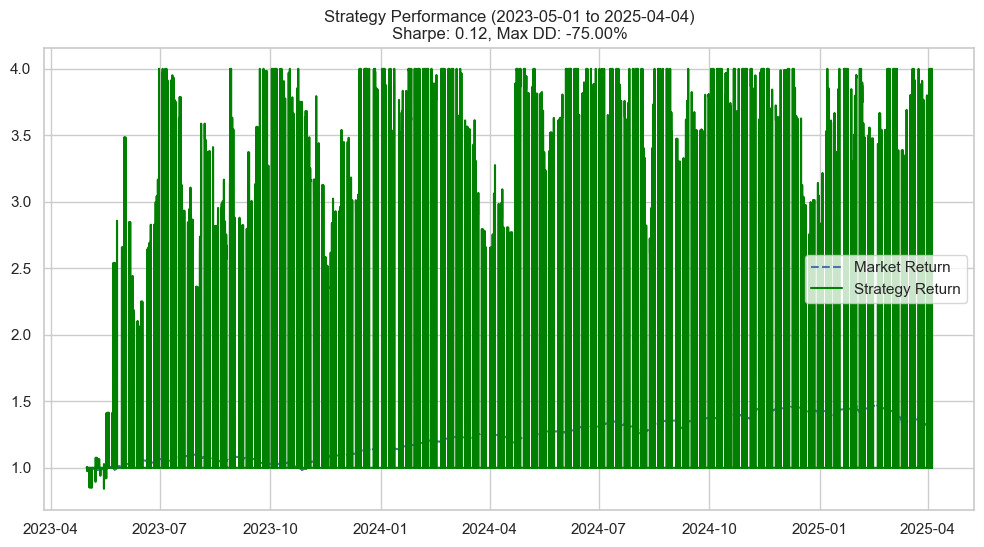

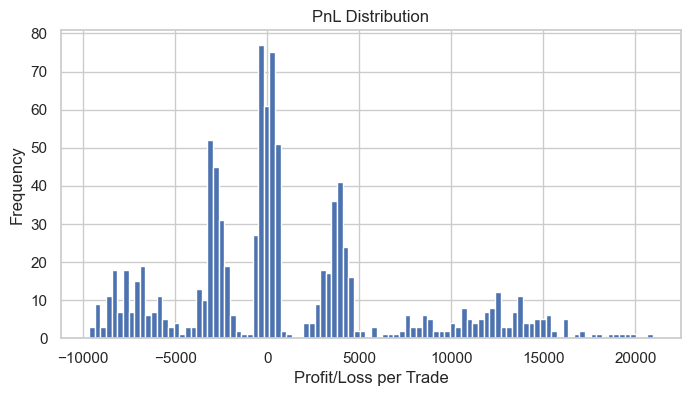

Grid search completed. Results saved to grid_search_results.csv.


In [27]:
'''param_grid = {
    'initial_capital': [25000],
    'risk_per_trade': [0.1, 0.2],
    'open_range_min': [10, 15, 20],
    'stop_loss_pct': [0.05, 0.1, 0.15],
    'take_profit_pct': [0.1, 0.2],
    'expiration_days': [1, 2, 3],
    'sigma': [0.2],  # You can expand this if you want to test different volatilities
    'max_trades': [1, 3],
    'max_minutes_in_trade': [60],
    'max_daily_loss_pct': [0.15],
    'max_portfolio_cap': [4],
    'max_drawdown_pct': [0.70],
    'max_consecutive_losses': [7],
    'trailing_stop_pct': [0.25],
    'decay_threshold': [0.03]
}'''

param_grid = {
    'initial_capital': [25000],
    'risk_per_trade': [0.2],
    'open_range_min': [20],
    'stop_loss_pct': [0.15],
    'take_profit_pct': [0.2],
    'expiration_days': [3],
    'sigma': [0.2],
    'max_trades': [3],
    'max_minutes_in_trade': [60],
    'max_daily_loss_pct': [0.15],
    'max_portfolio_cap': [4],
    'max_drawdown_pct': [0.70],
    'max_consecutive_losses': [7],
    'trailing_stop_pct': [0.25],
    'decay_threshold': [0.03]
}


df = pd.read_csv('df_2023_2025.csv', parse_dates=['datetime'])
df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert('America/New_York')

results = grid_search_strategy(df, param_grid)
results.to_csv("grid_search_results.csv", index=False)
print("Grid search completed. Results saved to grid_search_results.csv.")

In [ ]:
# Example usage
df = pd.read_csv('df_2023_2025.csv', parse_dates=['datetime'])
df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert('America/New_York')
generate_excel_report("SPY", df, "strategy_report.xlsx")


Large trade: 7937.26 at 2023-05-17 11:19:00-04:00
Large trade: 12387.27 at 2023-05-23 10:15:00-04:00
Large trade: 19345.51 at 2023-05-26 10:01:00-04:00
Large trade: 11878.00 at 2023-09-22 10:13:00-04:00
Large trade: 17438.20 at 2023-10-02 10:09:00-04:00
